<a href="https://colab.research.google.com/github/DannMacias/corn-leaf-disease-detection/blob/main/03_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b> Model comparison for corn leaf disease detection </b> 🌽🦠

In this notebook I will focus on the evaluation of different models for the detection of diseases in maize leaves.

The models to be compared are:
* EfficientNetB2 (Model base or control).
* AlexNet.
* GoogleNet.
* ResNet50.
* ViT.

The conditions of each of the experiments are:
* Same train and test data.
* 10 epochs.
* Batch size of 32.
* Criterion (or loss function): `CrossEntropyLoss`
* Optimizer: `Adam` with a learning rate of `1e-3`.

In [1]:
# Import basic libraries
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Get helper functions (for training and make predictions) from GitHub repo
# See https://github.com/DannMacias/corn-leaf-disease-detection
# Clone the repo
!git clone https://github.com/DannMacias/corn-leaf-disease-detection

# Move the folder helper_functions
!mv corn-leaf-disease-detection/helper_functions .

# Remove the remaining files from the repo of Google Colab
!rm -rf corn-leaf-disease-detection
from helper_functions import engine, predictions, utils

Cloning into 'corn-leaf-disease-detection'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 56 (delta 20), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (56/56), 2.93 MiB | 4.62 MiB/s, done.


# 1. Get the data

In [4]:
# Get the data from Google Drive
!unzip /content/drive/MyDrive/Pytorch_notes/corn-leaf-image-classification/corn-leaf-disease.zip > /dev/null

In [5]:
data_path = "/content/data"

In [6]:
# Download and import splitfolders
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Split the data train (80%) and test (20%)
splitfolders.ratio(input = data_path,
                   output = "splitted_data",
                   seed = 42,
                   ratio = (0.8, 0.2),
                   group_prefix = None,
                   move = False)

Copying files: 4188 files [00:00, 4772.75 files/s]


In [8]:
# Setup train and test directories
train_dir = "/content/splitted_data/train"
test_dir = "/content/splitted_data/val"

train_dir, test_dir

('/content/splitted_data/train', '/content/splitted_data/val')

In [9]:
# Create a function to make datasets and DataLoaders
import os
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int):
    
  # Use Image Folder to create datasets
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn datasets into DataLoaders
  train_dataloader = DataLoader(train_data,
                                batch_size = batch_size,
                                shuffle = True,
                                num_workers = num_workers,
                                pin_memory = True)
  
  test_dataloader = DataLoader(test_data,
                               batch_size = batch_size,
                               shuffle = False,
                               num_workers = num_workers,
                               pin_memory = True)
  
  return train_dataloader, test_dataloader, class_names

# Models

In [10]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 1e-3

## EficientNetB2 (control)

In [11]:
# Creating an EffNetB2 feature extractor
def create_effnetb2_model(num_classes: int = 4,
                          seed: int = 42):
  
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classfier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408,
                out_features = num_classes,
                bias = True)
      )
  
  return model, transforms

In [12]:
# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [13]:
# Create DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
    )

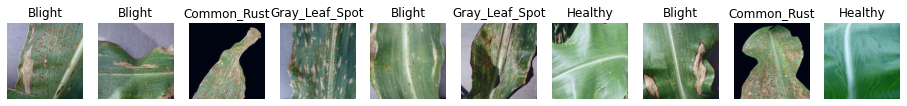

In [14]:
# Visualize images from the DataLoader
utils.view_dataloader_images(dataloader = train_dataloader_effnetb2,
                             class_names = class_names,
                             num_images = 10)

In [15]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = LEARNING_RATE)

# Train the model
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6013 | train_acc: 0.8036 | test_loss: 0.3606 | test_acc: 0.8947
Epoch: 2 | train_loss: 0.3177 | train_acc: 0.8910 | test_loss: 0.2853 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.2678 | train_acc: 0.9039 | test_loss: 0.2579 | test_acc: 0.9120
Epoch: 4 | train_loss: 0.2460 | train_acc: 0.9113 | test_loss: 0.2457 | test_acc: 0.9039
Epoch: 5 | train_loss: 0.2293 | train_acc: 0.9160 | test_loss: 0.2382 | test_acc: 0.9074
Epoch: 6 | train_loss: 0.2062 | train_acc: 0.9234 | test_loss: 0.2296 | test_acc: 0.9086
Epoch: 7 | train_loss: 0.2060 | train_acc: 0.9243 | test_loss: 0.2274 | test_acc: 0.9086
Epoch: 8 | train_loss: 0.2023 | train_acc: 0.9221 | test_loss: 0.2185 | test_acc: 0.9132
Epoch: 9 | train_loss: 0.1957 | train_acc: 0.9305 | test_loss: 0.2199 | test_acc: 0.9062
Epoch: 10 | train_loss: 0.1816 | train_acc: 0.9320 | test_loss: 0.2137 | test_acc: 0.9086


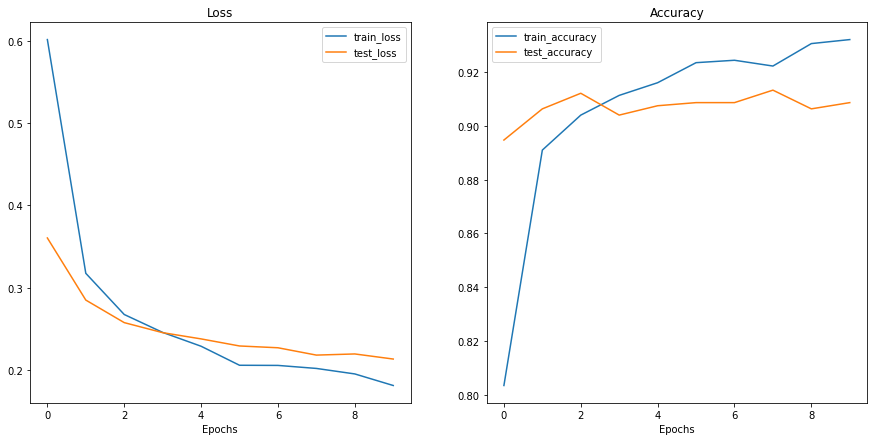

In [16]:
# Inspecting the loss curves
utils.plot_loss_curves(effnetb2_results)

In [17]:
# Saving the EffNetB2 feature extractor
utils.save_model(model = effnetb2,
                 target_dir = "models",
                 model_name = "pretrained_effnetb2.pth")

[INFO] Saving model to: models/pretrained_effnetb2.pth


In [18]:
# Checking the size of EffNetB2 feature extractor
from pathlib import Path

# Get the model size in bytes, then converted to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [19]:
# Count the number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

In [20]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size
                  }

effnetb2_stats

{'test_loss': 0.21372593352916064,
 'test_acc': 0.9085648148148148,
 'number_of_parameters': 7706630,
 'model_size (MB)': 29}

## AlexNet

In [21]:
# Check out AlexNet classifier layer
alexnet = torchvision.models.alexnet()
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
# Creating an AlexNet feature extractor
def create_alexnet_model(num_classes: int = 4,
                         seed: int = 42):
  
  # Create AlexNet pretrained weights, transforms and model
  weights = torchvision.models.AlexNet_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.alexnet(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classfier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.5, inplace = False),
      nn.Linear(in_features = 9216, out_features = 4096, bias = True),
      nn.ReLU(inplace = True),
      nn.Dropout(p = 0.5, inplace = False),
      nn.Linear(in_features = 4096, out_features = 4096, bias = True),
      nn.ReLU(inplace = True), 
      nn.Linear(in_features = 4096,
                out_features = num_classes,
                bias = True)
      )
  
  return model, transforms

In [23]:
# Create AlexNet model
alexnet, alexnet_transforms = create_alexnet_model()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [24]:
# Create DataLoaders
train_dataloader_alexnet, test_dataloader_alexnet, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = alexnet_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
    )

In [25]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = alexnet.parameters(),
                             lr = LEARNING_RATE)

# Train the model
alexnet_results = engine.train(model = alexnet,
                                train_dataloader = train_dataloader_alexnet,
                                test_dataloader = test_dataloader_alexnet,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8701 | train_acc: 0.8373 | test_loss: 0.2462 | test_acc: 0.8912
Epoch: 2 | train_loss: 0.2128 | train_acc: 0.9239 | test_loss: 0.2167 | test_acc: 0.9201
Epoch: 3 | train_loss: 0.1693 | train_acc: 0.9382 | test_loss: 0.2281 | test_acc: 0.9225
Epoch: 4 | train_loss: 0.1629 | train_acc: 0.9394 | test_loss: 0.2194 | test_acc: 0.9317
Epoch: 5 | train_loss: 0.1430 | train_acc: 0.9500 | test_loss: 0.2179 | test_acc: 0.9144
Epoch: 6 | train_loss: 0.1099 | train_acc: 0.9602 | test_loss: 0.2779 | test_acc: 0.9167
Epoch: 7 | train_loss: 0.0947 | train_acc: 0.9661 | test_loss: 0.3025 | test_acc: 0.9178
Epoch: 8 | train_loss: 0.1164 | train_acc: 0.9592 | test_loss: 0.2139 | test_acc: 0.9248
Epoch: 9 | train_loss: 0.0902 | train_acc: 0.9696 | test_loss: 0.2880 | test_acc: 0.9259
Epoch: 10 | train_loss: 0.0741 | train_acc: 0.9780 | test_loss: 0.2614 | test_acc: 0.9352


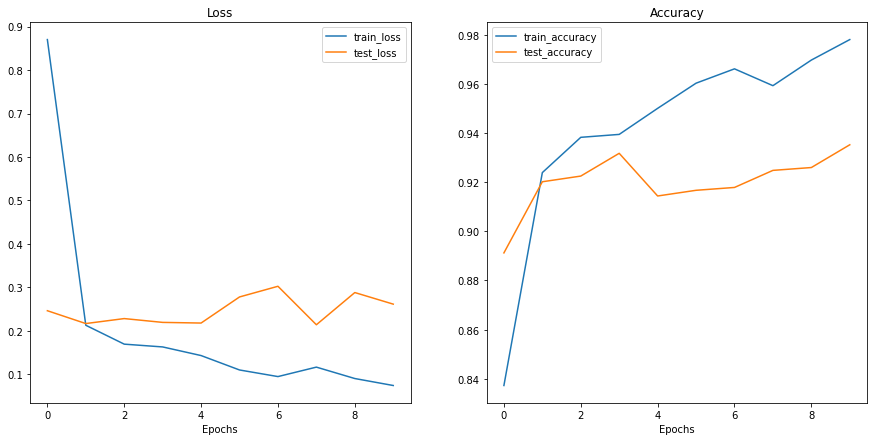

In [26]:
# Inspecting the loss curves
utils.plot_loss_curves(alexnet_results)

In [27]:
# Save the AlexNet model
utils.save_model(model = alexnet,
                 target_dir = "models",
                 model_name = "pretrained_alexnet.pth")

[INFO] Saving model to: models/pretrained_alexnet.pth


In [28]:
# Checking the size of AlexNet feature extractor
pretrained_alexnet_model_size = Path("models/pretrained_alexnet.pth").stat().st_size // (1024*1024)
print(f"Pretrained AlexNet feature extractor model size: {pretrained_alexnet_model_size} MB")

Pretrained AlexNet feature extractor model size: 217 MB


In [29]:
# Count the number of parameters in AlexNet
alexnet_total_params = sum(torch.numel(param) for param in alexnet.parameters())

In [30]:
# Create a dictionary with AlexNet statistics
alexnet_stats = {"test_loss": alexnet_results["test_loss"][-1],
                  "test_acc": alexnet_results["test_acc"][-1],
                  "number_of_parameters": alexnet_total_params,
                  "model_size (MB)": pretrained_alexnet_model_size
                  }

alexnet_stats

{'test_loss': 0.2613666122620809,
 'test_acc': 0.9351851851851852,
 'number_of_parameters': 57020228,
 'model_size (MB)': 217}

## GoogleNet

In [31]:
# Check out GoogleNet classifier layer
googlenet = torchvision.models.googlenet()
googlenet.fc

/usr/local/lib/python3.8/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Linear(in_features=1024, out_features=1000, bias=True)

In [32]:
# Creating an GoogleNet feature extractor
def create_googlenet_model(num_classes: int = 4,
                           seed: int = 42):
  
  # Create GoogleNet pretrained weights, transforms and model
  weights = torchvision.models.GoogLeNet_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.googlenet(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classfier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.fc = nn.Sequential(
      nn.Linear(in_features = 1024,
                out_features = num_classes,
                bias = True)
      )
  
  return model, transforms

In [33]:
# Create GoogleNet model
googlenet, googlenet_transforms = create_googlenet_model()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [34]:
# GoogleNet transforms
googlenet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [35]:
# Create DataLoaders
train_dataloader_googlenet, test_dataloader_googlenet, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = googlenet_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
    )

In [36]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = googlenet.parameters(),
                             lr = LEARNING_RATE)

# Train the model
googlenet_results = engine.train(model = googlenet,
                                train_dataloader = train_dataloader_googlenet,
                                test_dataloader = test_dataloader_googlenet,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6929 | train_acc: 0.7635 | test_loss: 0.4263 | test_acc: 0.8785
Epoch: 2 | train_loss: 0.3835 | train_acc: 0.8755 | test_loss: 0.3328 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.3270 | train_acc: 0.8877 | test_loss: 0.2947 | test_acc: 0.8981
Epoch: 4 | train_loss: 0.3047 | train_acc: 0.8955 | test_loss: 0.2778 | test_acc: 0.9051
Epoch: 5 | train_loss: 0.2648 | train_acc: 0.9130 | test_loss: 0.2717 | test_acc: 0.9005
Epoch: 6 | train_loss: 0.2609 | train_acc: 0.9029 | test_loss: 0.2517 | test_acc: 0.8993
Epoch: 7 | train_loss: 0.2568 | train_acc: 0.9064 | test_loss: 0.2617 | test_acc: 0.8993
Epoch: 8 | train_loss: 0.2488 | train_acc: 0.9082 | test_loss: 0.2450 | test_acc: 0.9132
Epoch: 9 | train_loss: 0.2367 | train_acc: 0.9141 | test_loss: 0.2480 | test_acc: 0.9062
Epoch: 10 | train_loss: 0.2198 | train_acc: 0.9253 | test_loss: 0.2332 | test_acc: 0.9120


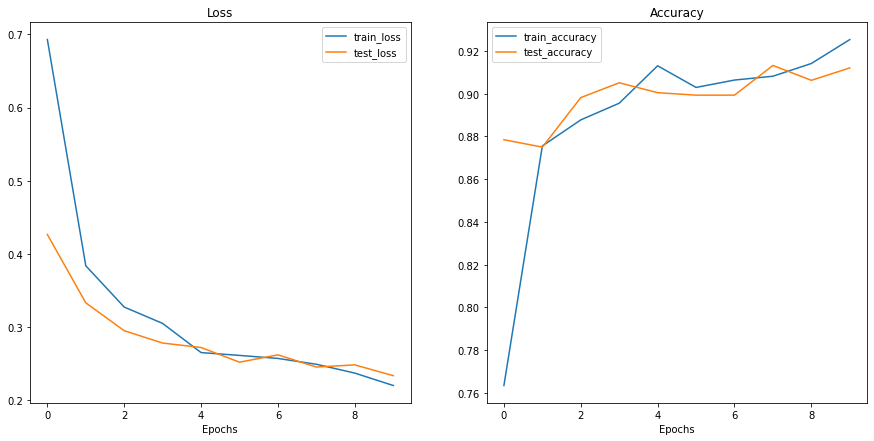

In [37]:
# Inspecting the loss curves
utils.plot_loss_curves(googlenet_results)

In [38]:
# Save the GoogleNet model
utils.save_model(model = googlenet,
                 target_dir = "models",
                 model_name = "pretrained_google_net.pth")

[INFO] Saving model to: models/pretrained_google_net.pth


In [39]:
# Checking the size of GoogleNet feature extractor
pretrained_googlenet_model_size = Path("models/pretrained_google_net.pth").stat().st_size // (1024*1024)
print(f"Pretrained GoogleNet feature extractor model size: {pretrained_googlenet_model_size} MB")

Pretrained GoogleNet feature extractor model size: 21 MB


In [40]:
# Count the number of parameters in GoogleNet
googlenet_total_params = sum(torch.numel(param) for param in googlenet.parameters())

In [41]:
# Create a dictionary with GoogleNet statistics
googlenet_stats = {"test_loss": googlenet_results["test_loss"][-1],
                  "test_acc": googlenet_results["test_acc"][-1],
                  "number_of_parameters": googlenet_total_params,
                  "model_size (MB)": pretrained_googlenet_model_size
                  }

googlenet_stats

{'test_loss': 0.23321022500318508,
 'test_acc': 0.9120370370370371,
 'number_of_parameters': 5604004,
 'model_size (MB)': 21}

## ResNet50

In [42]:
# Check out ResNet50 classifier layer
resnet50 = torchvision.models.resnet50()
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [43]:
# Creating an ResNet50 feature extractor
def create_resnet_model(num_classes: int = 4,
                        seed: int = 42):
  
  # Create ResNet50 pretrained weights, transforms and model
  weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.resnet50(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classfier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.fc = nn.Sequential(
      nn.Linear(in_features = 2048,
                out_features = num_classes,
                bias = True)
      )
  
  return model, transforms

In [44]:
# Create ResNet50 model
resnet, resnet_transforms = create_resnet_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [45]:
# Create DataLoaders
train_dataloader_resnet, test_dataloader_resnet, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = resnet_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
    )

In [46]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = resnet.parameters(),
                             lr = LEARNING_RATE)

# Train the model
resnet_results = engine.train(model = resnet,
                              train_dataloader = train_dataloader_resnet,
                              test_dataloader = test_dataloader_resnet,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6014 | train_acc: 0.8227 | test_loss: 0.3483 | test_acc: 0.8993
Epoch: 2 | train_loss: 0.2996 | train_acc: 0.9119 | test_loss: 0.2724 | test_acc: 0.9120
Epoch: 3 | train_loss: 0.2439 | train_acc: 0.9220 | test_loss: 0.2403 | test_acc: 0.9120
Epoch: 4 | train_loss: 0.2130 | train_acc: 0.9355 | test_loss: 0.2127 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.1968 | train_acc: 0.9346 | test_loss: 0.2065 | test_acc: 0.9178
Epoch: 6 | train_loss: 0.1686 | train_acc: 0.9504 | test_loss: 0.1966 | test_acc: 0.9271
Epoch: 7 | train_loss: 0.1618 | train_acc: 0.9489 | test_loss: 0.1867 | test_acc: 0.9317
Epoch: 8 | train_loss: 0.1498 | train_acc: 0.9491 | test_loss: 0.1821 | test_acc: 0.9271
Epoch: 9 | train_loss: 0.1434 | train_acc: 0.9534 | test_loss: 0.1802 | test_acc: 0.9317
Epoch: 10 | train_loss: 0.1298 | train_acc: 0.9651 | test_loss: 0.1740 | test_acc: 0.9352


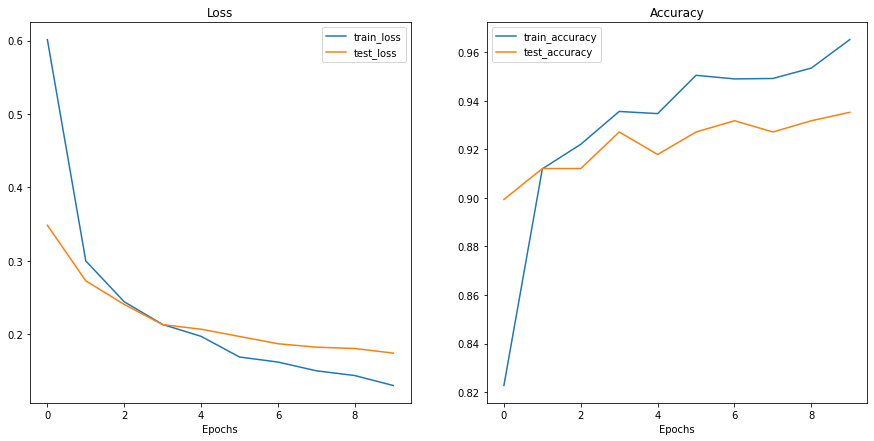

In [47]:
# Inspecting the loss curves
utils.plot_loss_curves(resnet_results)

In [48]:
# Save the ResNet50 model
utils.save_model(model = resnet,
                 target_dir = "models",
                 model_name = "pretrained_resnet50.pth")

[INFO] Saving model to: models/pretrained_resnet50.pth


In [49]:
# Checking the size of ResNet50 feature extractor
pretrained_resnet_model_size = Path("models/pretrained_resnet50.pth").stat().st_size // (1024*1024)
print(f"Pretrained ResNet50 feature extractor model size: {pretrained_resnet_model_size} MB")

Pretrained ResNet50 feature extractor model size: 90 MB


In [50]:
# Count the number of parameters in ResNet50
resnet_total_params = sum(torch.numel(param) for param in resnet.parameters())

In [51]:
# Create a dictionary with ResNet statistics
resnet50_stats = {"test_loss": resnet_results["test_loss"][-1],
                  "test_acc": resnet_results["test_acc"][-1],
                  "number_of_parameters": resnet_total_params,
                  "model_size (MB)": pretrained_resnet_model_size
                  }

resnet50_stats

{'test_loss': 0.1739669991829605,
 'test_acc': 0.9351851851851852,
 'number_of_parameters': 23516228,
 'model_size (MB)': 90}

## ViT (Visual Transformer)

In [52]:
# Check out ViT classifier layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [53]:
# Creating an ViT feature extractor
def create_vit_model(num_classes: int = 4,
                     seed: int = 42):
  
  # Create ViT pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classfier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features = 768,
                out_features = num_classes,
                bias = True)
  )
  
  return model, transforms

In [54]:
# Create ViT model
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [55]:
# Create DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
    )

In [56]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = LEARNING_RATE)

# Train the model
vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4227 | train_acc: 0.8531 | test_loss: 0.2473 | test_acc: 0.9120
Epoch: 2 | train_loss: 0.2088 | train_acc: 0.9292 | test_loss: 0.2047 | test_acc: 0.9225
Epoch: 3 | train_loss: 0.1678 | train_acc: 0.9410 | test_loss: 0.1776 | test_acc: 0.9352
Epoch: 4 | train_loss: 0.1466 | train_acc: 0.9510 | test_loss: 0.1649 | test_acc: 0.9433
Epoch: 5 | train_loss: 0.1296 | train_acc: 0.9560 | test_loss: 0.1573 | test_acc: 0.9456
Epoch: 6 | train_loss: 0.1169 | train_acc: 0.9610 | test_loss: 0.1521 | test_acc: 0.9491
Epoch: 7 | train_loss: 0.1111 | train_acc: 0.9623 | test_loss: 0.1489 | test_acc: 0.9537
Epoch: 8 | train_loss: 0.1024 | train_acc: 0.9659 | test_loss: 0.1482 | test_acc: 0.9525
Epoch: 9 | train_loss: 0.0948 | train_acc: 0.9711 | test_loss: 0.1418 | test_acc: 0.9525
Epoch: 10 | train_loss: 0.0888 | train_acc: 0.9723 | test_loss: 0.1418 | test_acc: 0.9549


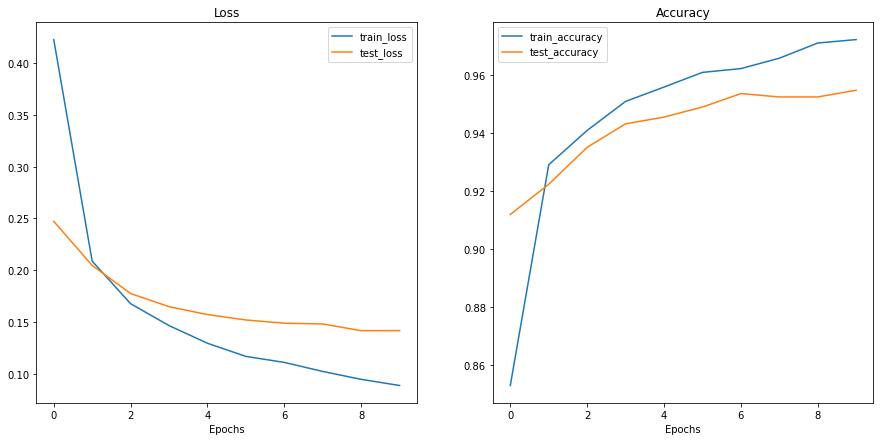

In [57]:
# Inspecting the loss curves
utils.plot_loss_curves(vit_results)

In [58]:
# Save the ViT model
utils.save_model(model = vit,
                 target_dir = "models",
                 model_name = "pretrained_vit_b_16.pth")

[INFO] Saving model to: models/pretrained_vit_b_16.pth


In [59]:
# Checking the size of ViT feature extractor
pretrained_vit_model_size = Path("models/pretrained_vit_b_16.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [60]:
# Count the number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

In [61]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
             
vit_stats

{'test_loss': 0.14184271215668154,
 'test_acc': 0.9548611111111112,
 'number_of_parameters': 85801732,
 'model_size (MB)': 327}

# Making predictions with our trained models

Since I'd like to make predictions across all the images in the test set, let's first get a list of all of the test image paths.

In [62]:
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('/content/splitted_data/val/Healthy/Corn_Health (403).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (804).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (486).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (829).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (495).jpg')]

In [63]:
import pathlib
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # Create an empty list to store prediction dictionaires
    pred_list = []
    
    # Loop through target paths
    for path in tqdm(paths):
        
        # Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # Start the prediction timer
        start_time = timer()
        
        # Open image path
        img = Image.open(path)
        
        # Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) 
            pred_prob = torch.softmax(pred_logit, dim=1) 
            pred_label = torch.argmax(pred_prob, dim=1) 
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # Return list of prediction dictionaries
    return pred_list

## Making and timming predictions with the models

### EffNetB2

In [64]:
# Make predictions with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names = class_names,
                                          device = "cpu") # Make predictions on CPU

  0%|          | 0/334 [00:00<?, ?it/s]

In [65]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/content/splitted_data/val/Healthy/Corn_Health...,Healthy,0.9984,Healthy,0.3653,True
1,/content/splitted_data/val/Healthy/Corn_Health...,Healthy,0.9993,Healthy,0.1104,True
2,/content/splitted_data/val/Healthy/Corn_Health...,Healthy,0.9991,Healthy,0.1081,True
3,/content/splitted_data/val/Healthy/Corn_Health...,Healthy,0.9975,Healthy,0.1087,True
4,/content/splitted_data/val/Healthy/Corn_Health...,Healthy,0.9962,Healthy,0.1062,True


In [66]:
# Check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     291
False     43
Name: correct, dtype: int64

In [67]:
# Find the average time per prediction
effnetb2_avg_time_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_avg_time_pred} seconds")

EffNetB2 average time per prediction: 0.1289 seconds


In [68]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_avg_time_pred

### AlexNet

In [69]:
# Make predictions with AlexNet
alexnet_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = alexnet,
                                          transform = alexnet_transforms,
                                          class_names = class_names,
                                          device = "cpu") # Make predictions on CPU

  0%|          | 0/334 [00:00<?, ?it/s]

In [70]:
# Turn the test_pred_dicts into a DataFrame
alexnet_test_pred_df = pd.DataFrame(alexnet_test_pred_dicts)

# Check the number of correct predictions
alexnet_test_pred_df.correct.value_counts()

True     305
False     29
Name: correct, dtype: int64

In [71]:
# Find the average time per prediction
alexnet_avg_time_pred = round(alexnet_test_pred_df.time_for_pred.mean(), 4)
print(f"AlexNet average time per prediction: {alexnet_avg_time_pred} seconds")

# Add AlexNet average prediction time to stats dictionary
alexnet_stats["time_per_pred_cpu"] = alexnet_avg_time_pred

AlexNet average time per prediction: 0.0611 seconds


### GoogleNet

In [72]:
# Make predictions with GoogleNet
googlenet_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                           model = googlenet,
                                           transform = googlenet_transforms,
                                           class_names = class_names,
                                           device = "cpu") # Make predictions on CPU

  0%|          | 0/334 [00:00<?, ?it/s]

In [73]:
# Turn the test_pred_dicts into a DataFrame
googlenet_test_pred_df = pd.DataFrame(googlenet_test_pred_dicts)

# Check the number of correct predictions
googlenet_test_pred_df.correct.value_counts()

True     293
False     41
Name: correct, dtype: int64

In [74]:
# Find the average time per prediction
googlenet_avg_time_pred = round(googlenet_test_pred_df.time_for_pred.mean(), 4)
print(f"GoogleNet average time per prediction: {googlenet_avg_time_pred} seconds")

# Add GoogleNet average prediction time to stats dictionary
googlenet_stats["time_per_pred_cpu"] = googlenet_avg_time_pred

GoogleNet average time per prediction: 0.1272 seconds


### ResNet50

In [75]:
# Make predictions with ResNet50
resnet_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                        model = resnet,
                                        transform = resnet_transforms,
                                        class_names = class_names,
                                        device = "cpu") # Make predictions on CPU

  0%|          | 0/334 [00:00<?, ?it/s]

In [76]:
# Turn the test_pred_dicts into a DataFrame
resnet_test_pred_df = pd.DataFrame(resnet_test_pred_dicts)

# Check the number of correct predictions
resnet_test_pred_df.correct.value_counts()

True     311
False     23
Name: correct, dtype: int64

In [78]:
# Find the average time per prediction
resnet_avg_time_pred = round(resnet_test_pred_df.time_for_pred.mean(), 4)
print(f"ResNet50 average time per prediction: {resnet_avg_time_pred} seconds")

# Add ResNet50 average prediction time to stats dictionary
resnet50_stats["time_per_pred_cpu"] = resnet_avg_time_pred

ResNet50 average time per prediction: 0.2066 seconds


### ViT

In [79]:
# Make predictions with ViT
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform = vit_transforms,
                                     class_names = class_names,
                                     device = "cpu") # Make predictions on CPU

  0%|          | 0/334 [00:00<?, ?it/s]

In [80]:
# Turn the test_pred_dicts into a DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)

# Check the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     314
False     20
Name: correct, dtype: int64

In [81]:
# Find the average time per prediction
vit_avg_time_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_avg_time_pred} seconds")

# Add ViT average prediction time to stats dictionary
vit_stats["time_per_pred_cpu"] = vit_avg_time_pred

ViT average time per prediction: 0.6734 seconds


# Comparing models

In [82]:
# Turn stats dictionaries into DataFrames
models_df = pd.DataFrame([effnetb2_stats, alexnet_stats, googlenet_stats, resnet50_stats, vit_stats])

# Add column for model names
models_df["model"] = ["EffNetB2", "AlexNet", "GoogleNet", "ResNet50", "ViT"]

# Convert accuracy to percentage
models_df["test_acc"] = round(models_df["test_acc"]*100, 2)

models_df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.213726,90.86,7706630,29,0.1289,EffNetB2
1,0.261367,93.52,57020228,217,0.0611,AlexNet
2,0.233210,91.20,5604004,21,0.1272,GoogleNet
3,0.173967,93.52,23516228,90,0.2066,ResNet50
4,0.141843,95.49,85801732,327,0.6734,ViT


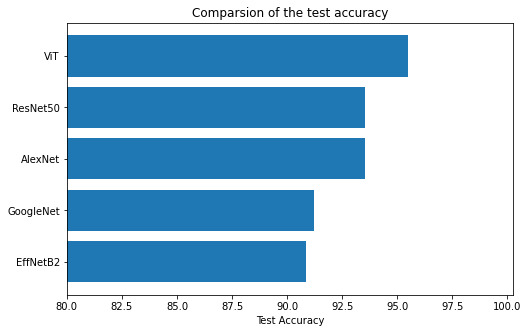

In [89]:
# Compare test_acc
import matplotlib.pyplot as plt

# Sort values from test_acc (for visualization purposes)
model_df_test_acc_sorted = models_df.sort_values(by = "test_acc", ascending = True)

# Plot the results
plt.figure(figsize = (8, 5))
plt.barh(y = model_df_test_acc_sorted.model, 
         width = model_df_test_acc_sorted.test_acc)
plt.title("Comparsion of the test accuracy")
plt.xlim(80) # Zoom for 80%
plt.xlabel("Test Accuracy");

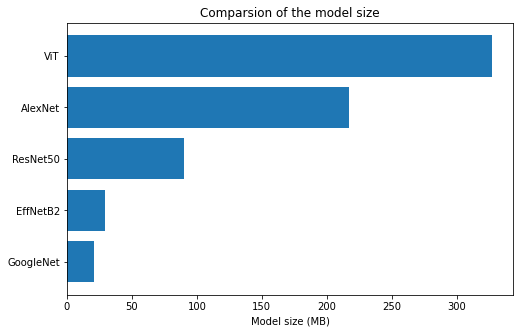

In [92]:
# Compare Model Size
# Sort values from model_size (for visualization purposes)
model_df_model_size_sorted = models_df.sort_values(by = "model_size (MB)", ascending = True)

# Plot the results
plt.figure(figsize = (8, 5))
plt.barh(y = model_df_model_size_sorted.model, 
         width = model_df_model_size_sorted["model_size (MB)"])
plt.title("Comparsion of the model size")
plt.xlabel("Model size (MB)");

ResNet50 and AlexNet have the same test accuracy, but ResNet50 is smaller than AlexNet (2.4 times smaller). At the moment, ResNet50 appears to be the model of choice, followed by GoogleNet.

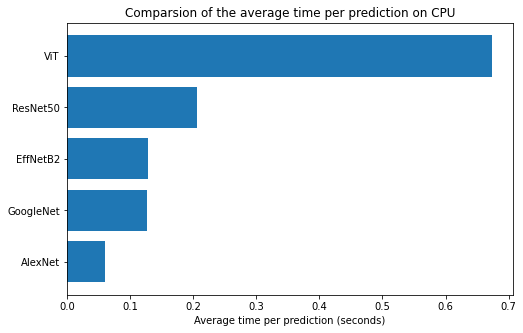

In [93]:
# Compare Time per prediction
# Sort values from time_per_pred_cpu (for visualization purposes)
model_df_time_pred_sorted = models_df.sort_values(by = "time_per_pred_cpu", ascending = True)

# Plot the results
plt.figure(figsize = (8, 5))
plt.barh(y = model_df_time_pred_sorted.model, 
         width = model_df_time_pred_sorted.time_per_pred_cpu)
plt.title("Comparsion of the average time per prediction on CPU")
plt.xlabel("Average time per prediction (seconds)");

AlexNet is quickest, but it is a model that, although it is accurate, is too big and for our needs (we want a model that is suitable for use in e.g. mobile phones), it is best to use models such as
* GoogleNet.
* ResNet50.

## GoogleNet vs ResNet50 comparison

I'd to divide the ResNet50 model statistics by the GoogleNet model statistics to find out the different ratios between the models.

In [94]:
# Compare ResNet50 to GoogleNet across different characteristics
pd.DataFrame(data = (models_df.set_index("model").loc["ResNet50"] / models_df.set_index("model").loc["GoogleNet"]), # divide ResNet50 statistics by GoogleNet statistics
             columns = ["ResNet50 to GoogleNet ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ResNet50 to GoogleNet ratios,0.745966,1.025439,4.196326,4.285714,1.624214


ResNet50 is 4 times bigger than GoogleNet, and 1.6 times slower than GoogleNet when predicting. ResNet50 is the largest and slowest to predict.

## Visualizing the speed vs. performance tradeoff

Create a scatter plot from the comparison DataFrame to compare `time_per_pred_cpu` and `test_acc` values.

In [100]:
# Get a list of colors for visualization purpose (based on ColorBrewer)
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

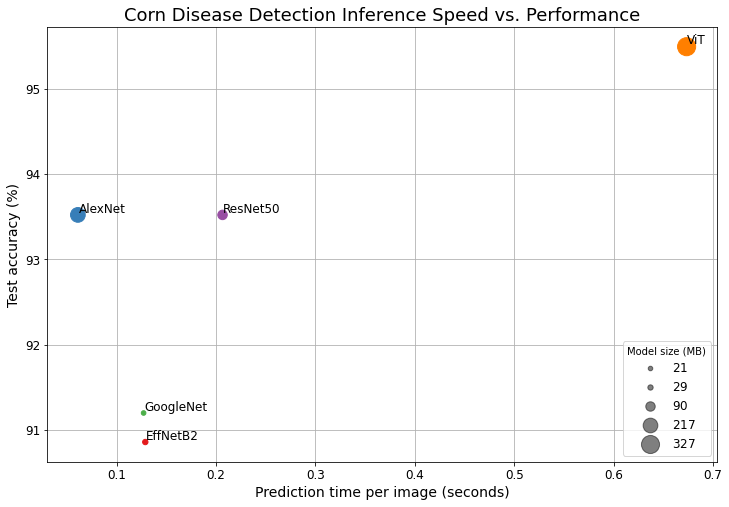

In [110]:
# Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize = (12, 8))
scatter = ax.scatter(data = models_df,
                     x = "time_per_pred_cpu",
                     y = "test_acc",
                     c = colors,
                     s = "model_size (MB)") # size the dots by the model sizes

# Add titles, labels and customize fonts
ax.set_title("Corn Disease Detection Inference Speed vs. Performance", fontsize = 18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize = 14)
ax.set_ylabel("Test accuracy (%)", fontsize = 14)
ax.tick_params(axis = "both", labelsize = 12)
ax.grid(True)

# Annotate with model names
for index, row in models_df.iterrows():
  ax.annotate(text = row["model"], 
              xy = (row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.03),
              size = 12)
  
# Creates a legend based on model sizes
handles, labels = scatter.legend_elements(prop = "sizes", alpha = 0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = "lower right",
                              title = "Model size (MB)",
                              fontsize = 12)

# Save the figure
plt.savefig("models/corn-disease-detection-inference-speed-vs-performance.png")

# Show the figure
plt.show()

# Conclusions

Of the models evaluated, ViT has the highest accuracy. However, this comes at the cost of a larger size and a longer time to make predictions. If we want to use the model, especially on mobile devices, the size of ViT is a major limitation. 

Therefore, even though it has the best `test_accuracy` value, I discard ViT.

ResNet50 has the same test accuracy value as AlexNet, has a smaller size, but takes longer to infer (1.6 times slower than GoogleNet).

GoogleNet has the smallest size, it is fast to make inferences, but its accuracy is 91%, which is the second worst accuracy, only beaten by EffNetB2.

Since we are interested in being able to deploy the model, the model size is a factor to be taken into account. Therefore, we chose the GoogleNet and ResNet50 models, since they have a smaller size, in addition to being fast in inference and having an accuracy greater than 91%.